In [1]:
from pincell_moment_utils import postprocessing as pp
import time

# First extract the surface fluxes from the tallies, then use them to compute the moments of the expansion 
mesh_tally = pp.SurfaceMeshTally('../data/source_statepoint.100.h5')
coefficients = pp.compute_coefficients(mesh_tally, 7, 5, expansion_type='bernstein_bernstein')

expansion = pp.surface_expansion(coefficients, mesh_tally.energy_filters, expansion_type='bernstein_bernstein')

start = time.time()
samples = expansion.generate_samples(100000, num_cores=8, progress=True)
stop = time.time()
print(stop - start)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/mlouis9/miniconda3/envs/openmc-env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 779/779 [00:04<00:00, 168.82it/s]


42.141273975372314


## Verify the Spatial-Angle Distribution of Generated Samples
First we plot the generated sample points and compare them with the corresponding plots of the flux generated in previous tests.

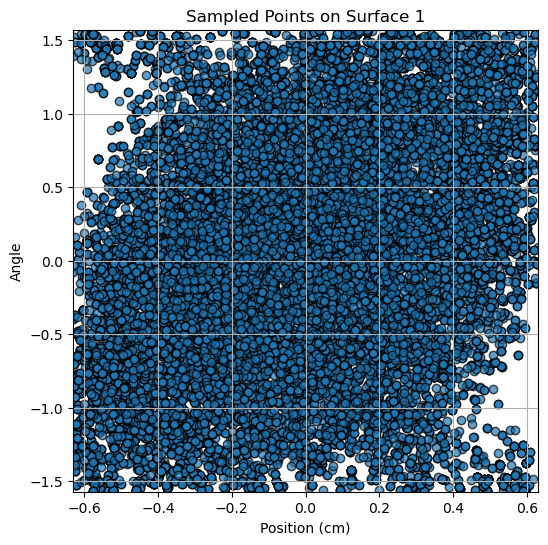

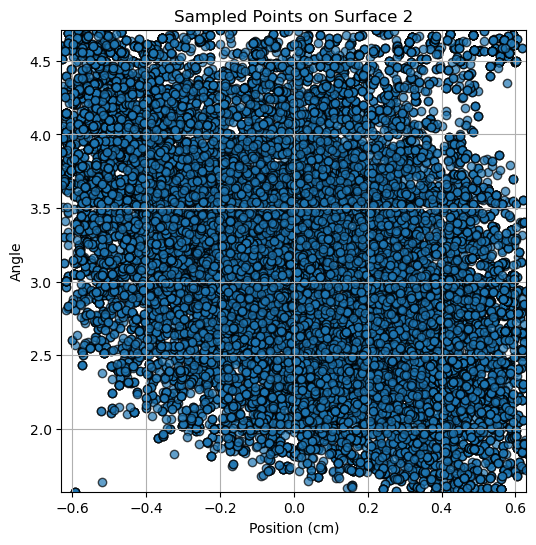

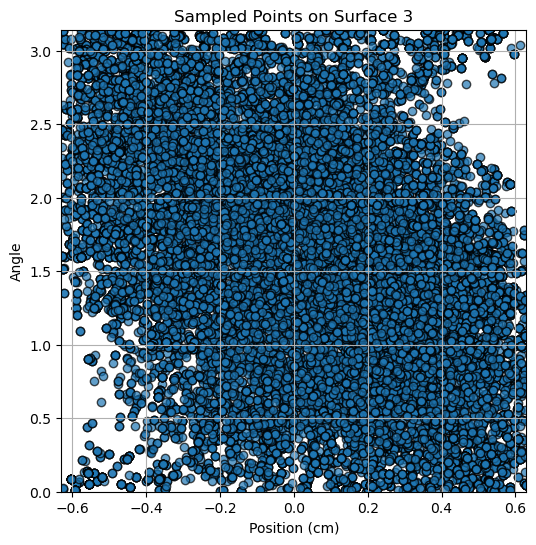

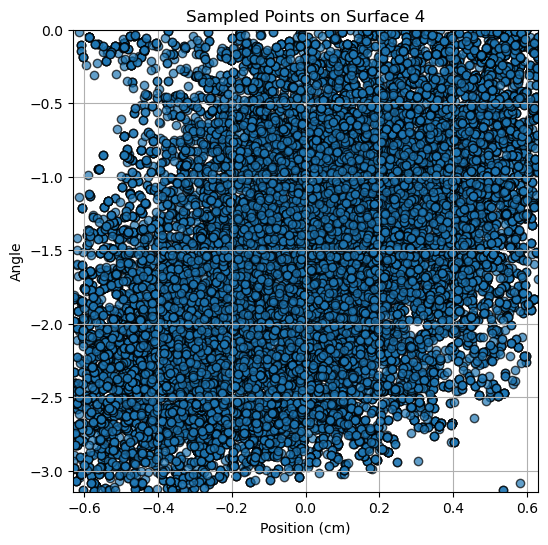

In [2]:
import matplotlib.pyplot as plt
from pincell_moment_utils import config
from pincell_moment_utils.plotting import reconstruction_comparison

for surface in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[surface][:,0], samples[surface][:,1], marker='o', alpha=0.7, edgecolors='k')
    plt.xlabel('Position (cm)')
    plt.ylabel('Angle')
    plt.xlim(config.SPATIAL_BOUNDS[surface][0], config.SPATIAL_BOUNDS[surface][1])
    plt.ylim(config.ANGULAR_BOUNDS[surface][0], config.ANGULAR_BOUNDS[surface][1])
    plt.title(f'Sampled Points on Surface {surface +1}')
    plt.grid()

Compare with the corresponding plots of the flux through the most probable energy slice

[-1.49225651 -1.33517688 -1.17809725 -1.02101761 -0.86393798 -0.70685835
 -0.54977871 -0.39269908 -0.23561945 -0.07853982  0.07853982  0.23561945
  0.39269908  0.54977871  0.70685835  0.86393798  1.02101761  1.17809725
  1.33517688  1.49225651]


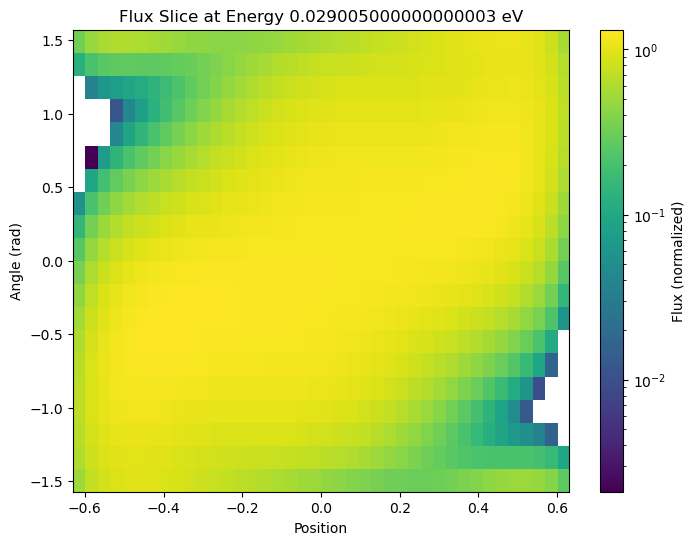

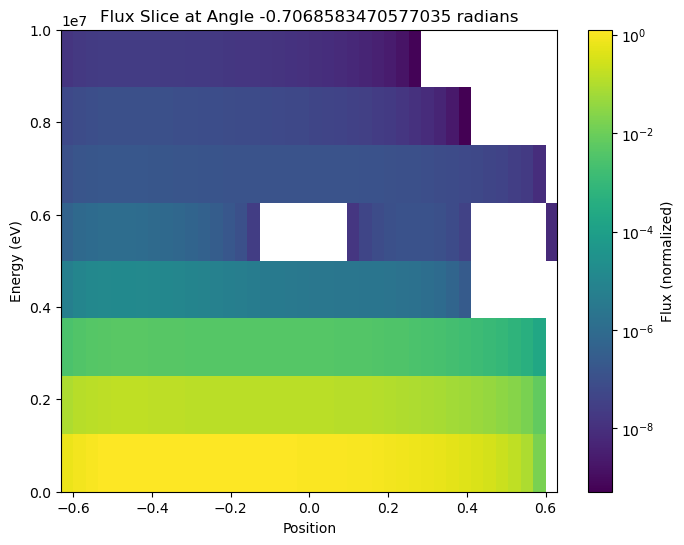

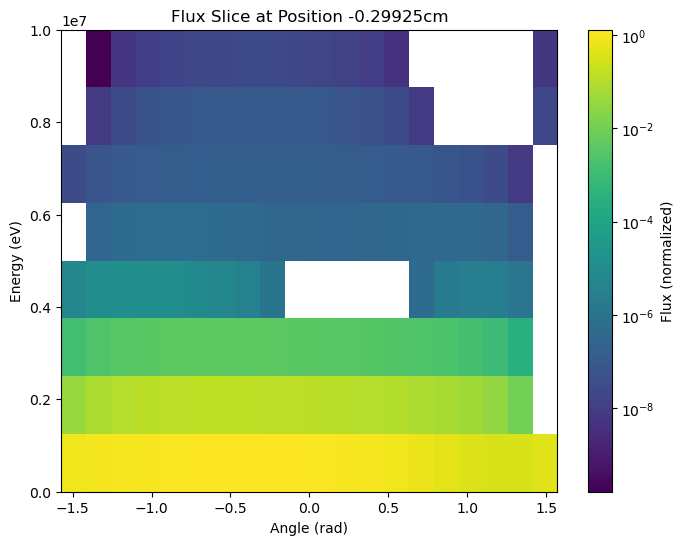

[1.64933614 1.80641578 1.96349541 2.12057504 2.27765467 2.43473431
 2.59181394 2.74889357 2.9059732  3.06305284 3.22013247 3.3772121
 3.53429174 3.69137137 3.848451   4.00553063 4.16261027 4.3196899
 4.47676953 4.63384916]


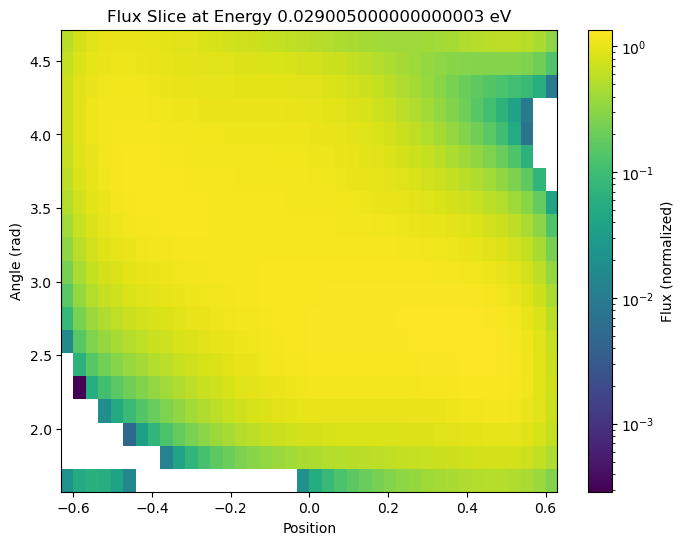

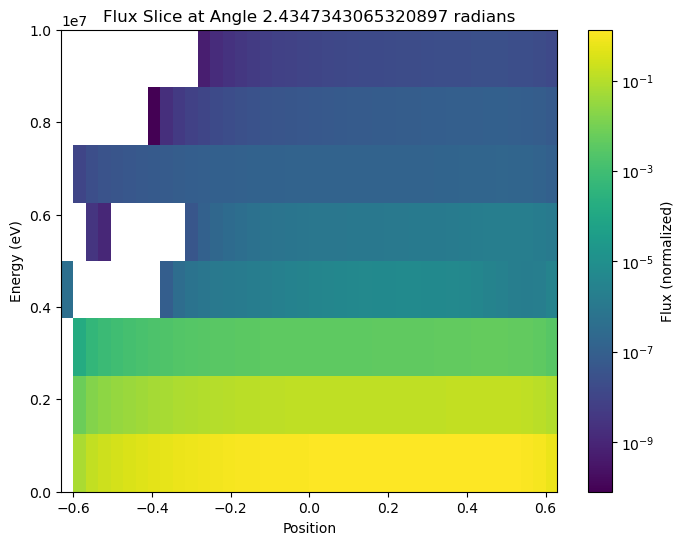

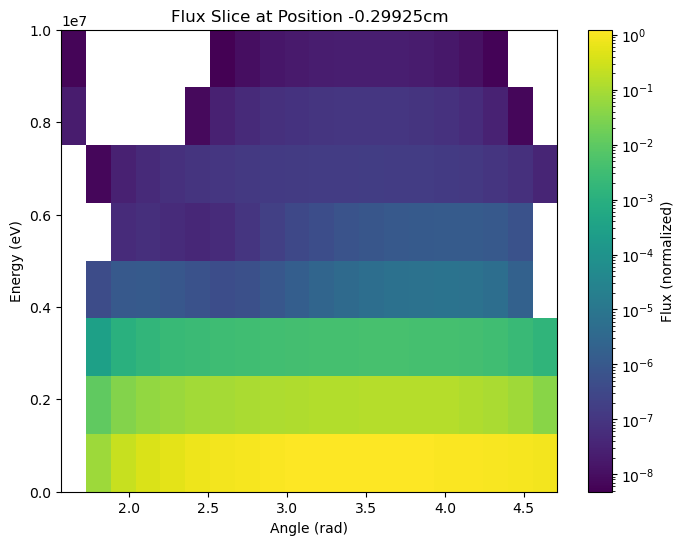

[0.07853982 0.23561945 0.39269908 0.54977871 0.70685835 0.86393798
 1.02101761 1.17809725 1.33517688 1.49225651 1.64933614 1.80641578
 1.96349541 2.12057504 2.27765467 2.43473431 2.59181394 2.74889357
 2.9059732  3.06305284]


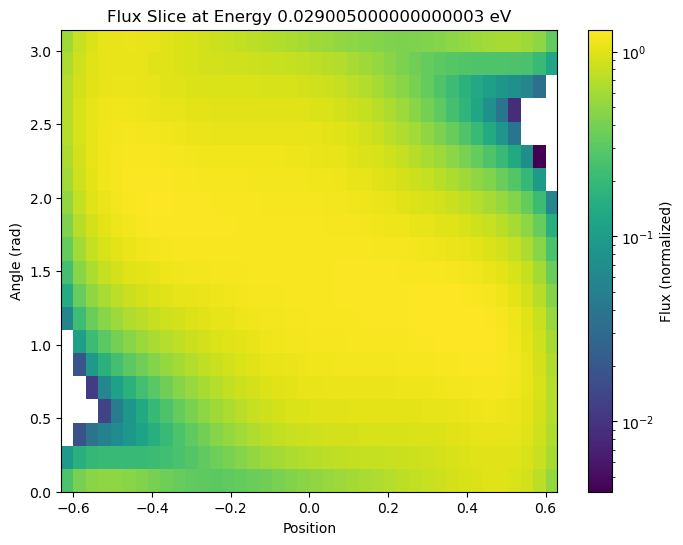

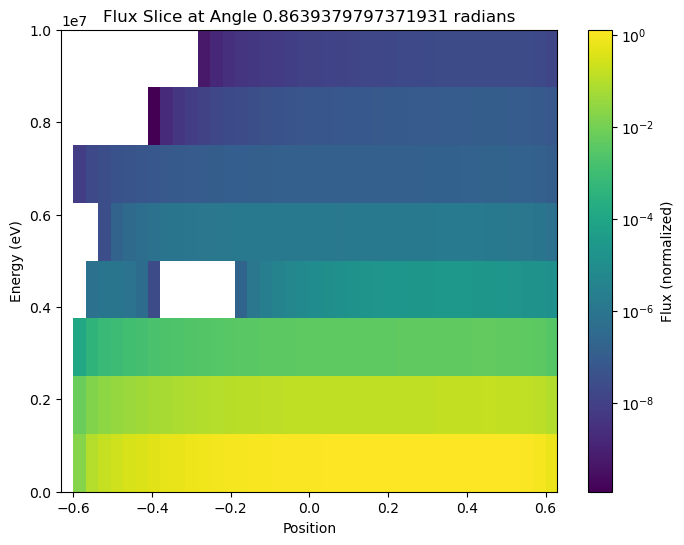

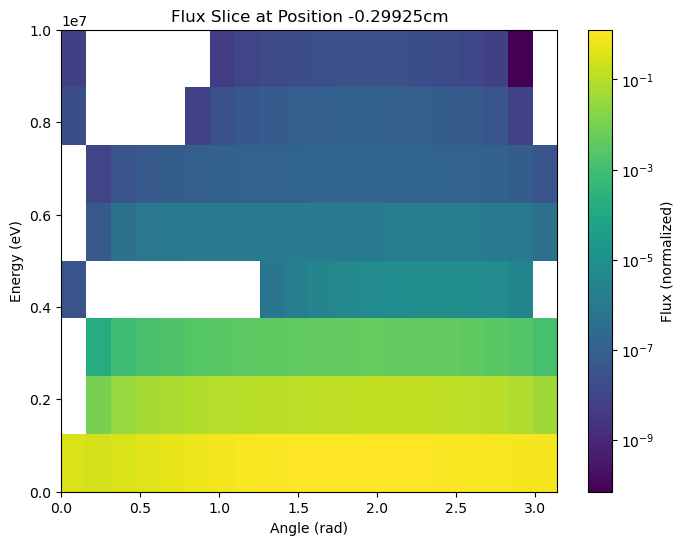

[-3.06305284 -2.9059732  -2.74889357 -2.59181394 -2.43473431 -2.27765467
 -2.12057504 -1.96349541 -1.80641578 -1.64933614 -1.49225651 -1.33517688
 -1.17809725 -1.02101761 -0.86393798 -0.70685835 -0.54977871 -0.39269908
 -0.23561945 -0.07853982]


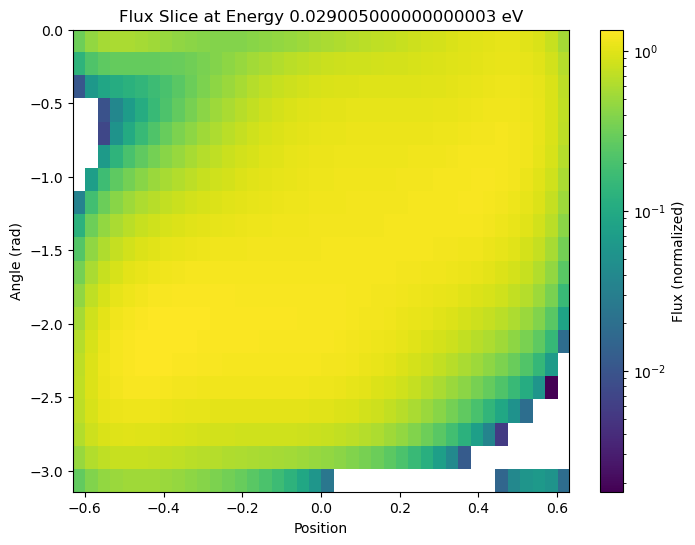

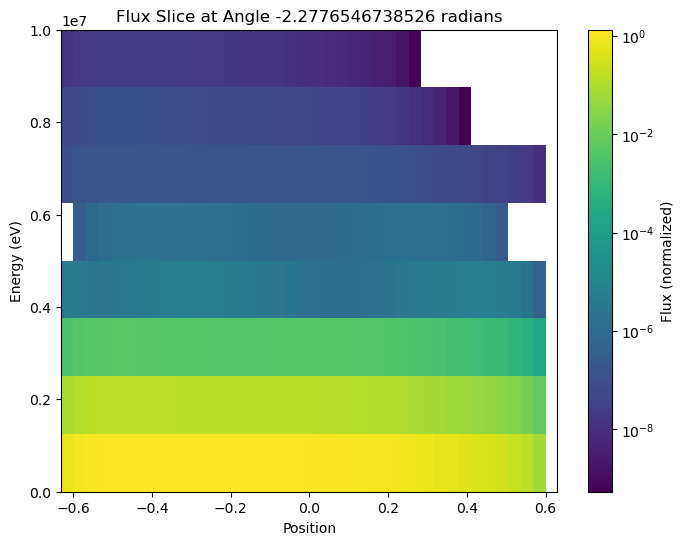

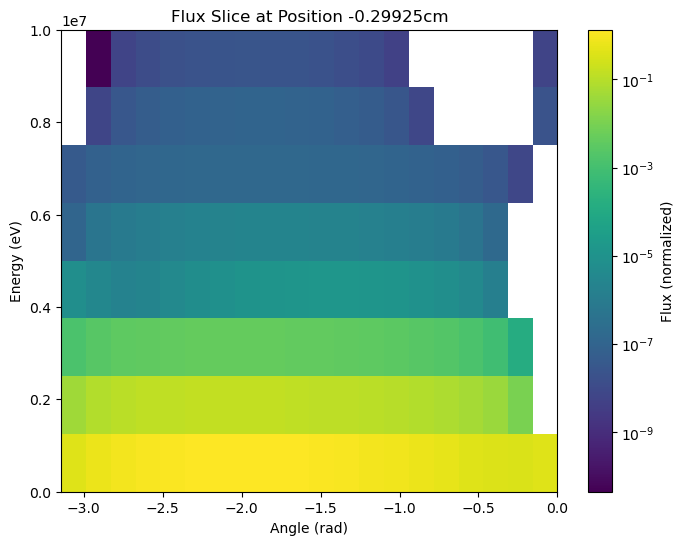

In [3]:
for surface in range(4):
    reconstruction_comparison(expansion, mesh_tally, 10, 5, 0, surface, option='expansion')

Make sure the spatial points are all within the proper bounds

In [5]:
import numpy as np

for surface in range(4):
    print(f"Max  {np.max(samples[surface][:,0])}, pitch/2={config.PITCH/2}")
    print(f"Min {np.min(samples[surface][:,0])}, -pitch/2={-config.PITCH/2}")

Max  0.6288436282286914, pitch/2=0.63
Min -0.6296742176494021, -pitch/2=-0.63
Max  0.6297574279884196, pitch/2=0.63
Min -0.6299624061216206, -pitch/2=-0.63
Max  0.6298695607826981, pitch/2=0.63
Min -0.62986442770541, -pitch/2=-0.63
Max  0.6297246282505906, pitch/2=0.63
Min -0.6298969205121745, -pitch/2=-0.63


## Benchmark the Energy Distribution of the points
Lastly, it's prudent to plot the energy distribution of the points

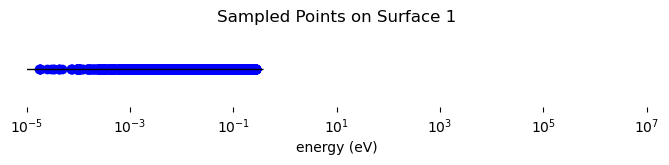

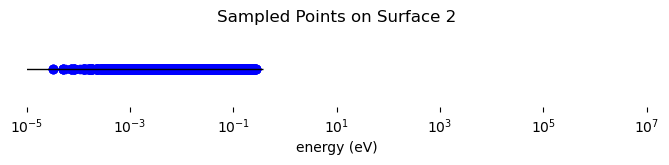

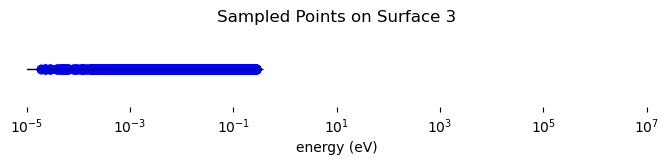

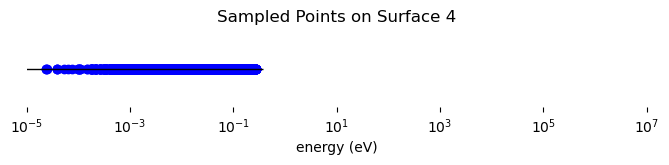

In [6]:
energy_bounds = expansion.energy_bounds

for surface in range(4):
    plt.figure(figsize=(8, 1))  # Make it a horizontal strip

    # Plot the points on a line
    plt.scatter(samples[surface][:,2], np.zeros_like(samples[surface][:,2]), marker='o', color='b')

    # Draw the line
    plt.hlines(0, min(samples[surface][:,2]) - 0.1, max(samples[surface][:,2]) + 0.1, colors='black', linewidth=1)

    # Remove y-axis
    plt.yticks([])
    plt.box(False)  # Remove the surrounding box
    plt.xlabel('energy (eV)')
    plt.xlim(energy_bounds[surface][0], energy_bounds[surface][1])
    plt.xscale('log')
    plt.title(f'Sampled Points on Surface {surface + 1}')

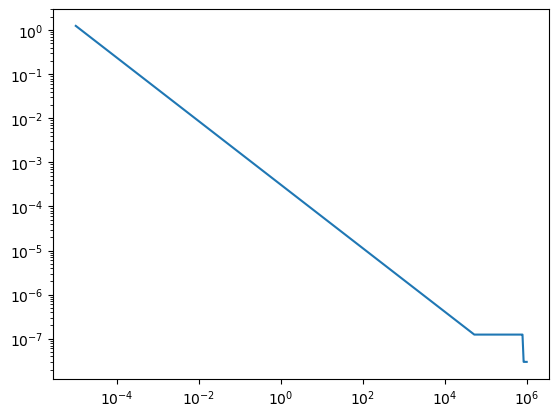

In [7]:
plt.plot(np.linspace(1E-05, 1E+06, 20), [ expansion.flux_functions[0](0,0, E) for E in np.linspace(1E-05, 1E+06, 20)])
plt.yscale('log')
plt.xscale('log')

Calculate the ratio of "high energy" source particles to "low energy" source particles

In [8]:
print(np.size(np.where(samples[0][:, 2] < 1))/np.size(np.where(samples[0][:, 2] > 1)))

ZeroDivisionError: division by zero

Though there still seems to be many more high energy samples that we'd expect, this could very well be consistent with the distribution since, although the density at higher energies is much smaller, the energy range is much larger. In any case, this can be controlled by biasing the initial samples used for the MCMC sampling algorithm

## High Energy Benchmark
The source used for the computation of `'../data/source_statepoint.100.h5'` was a very low energy source intended to induce a large number of fissions to create an interesting outgoing flux profile. The sampler is currently optimized for this low energy peaked flux, so to see if the number of burn in samples is sufficient for the ensemble sampler to converge to a reasonable equilibrium regardless of this low energy bias, we test on data generated from a high energy (watt fission spectrum) source `'../data/watt_statepoint.100.h5'`

In [12]:
from pincell_moment_utils import postprocessing as pp
import time

# First extract the surface fluxes from the tallies, then use them to compute the moments of the expansion 
mesh_tally = pp.SurfaceMeshTally('../data/watt_statepoint.100.h5')
coefficients = pp.compute_coefficients(mesh_tally, 7, 5, expansion_type='bernstein_bernstein')

expansion = pp.surface_expansion(coefficients, mesh_tally.energy_filters, expansion_type='bernstein_bernstein')

start = time.time()
samples = expansion.generate_samples(100000, num_cores=8, method='ensemble', burn_in=1000, use_log_energy=True, progress=True)
stop = time.time()
print(stop - start)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/mlouis9/miniconda3/envs/openmc-env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 775/775 [00:04<00:00, 165.16it/s]


43.3788321018219


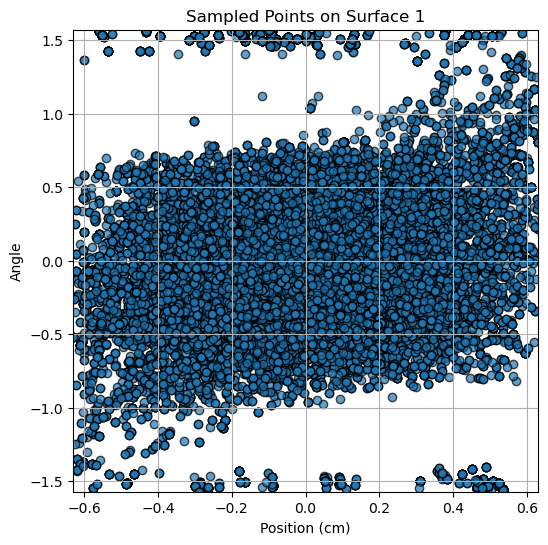

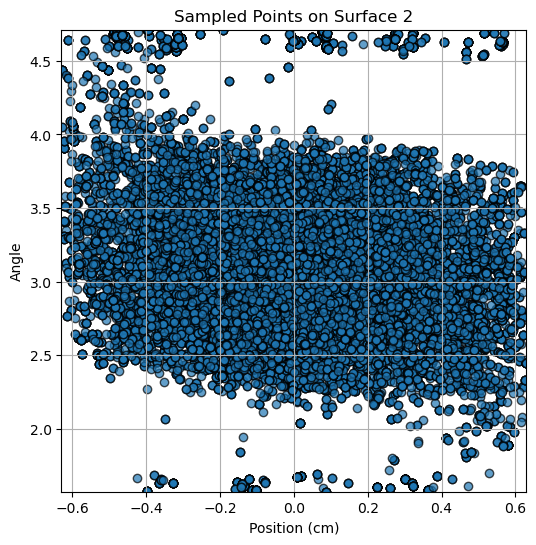

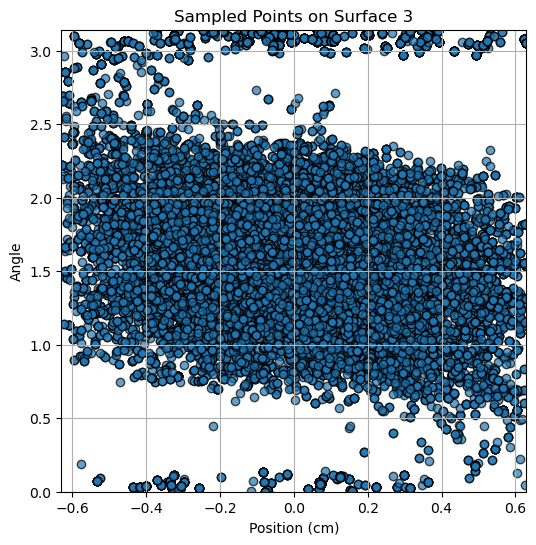

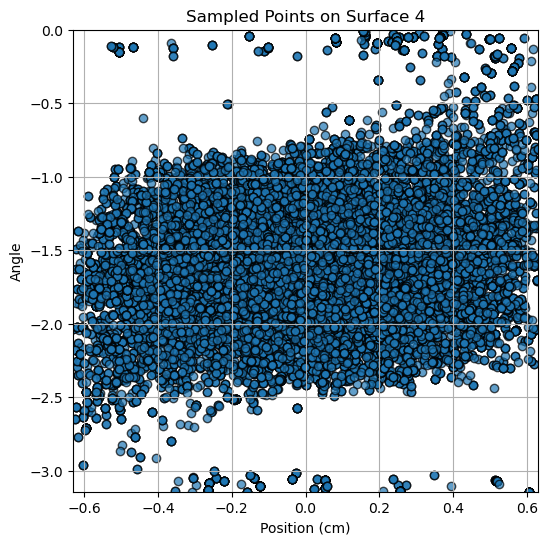

In [13]:
import matplotlib.pyplot as plt
from pincell_moment_utils import config
from pincell_moment_utils.plotting import reconstruction_comparison

for surface in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[surface][:,0], samples[surface][:,1], marker='o', alpha=0.7, edgecolors='k')
    plt.xlabel('Position (cm)')
    plt.ylabel('Angle')
    plt.xlim(config.SPATIAL_BOUNDS[surface][0], config.SPATIAL_BOUNDS[surface][1])
    plt.ylim(config.ANGULAR_BOUNDS[surface][0], config.ANGULAR_BOUNDS[surface][1])
    plt.title(f'Sampled Points on Surface {surface +1}')
    plt.grid()

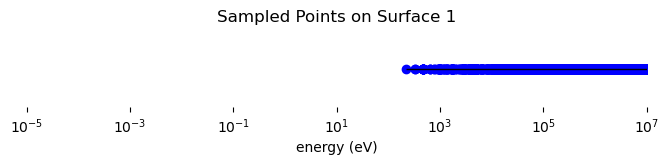

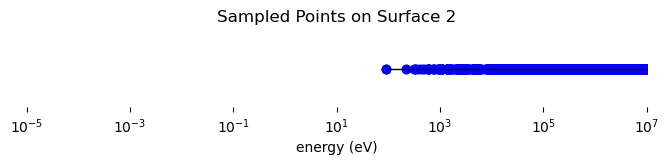

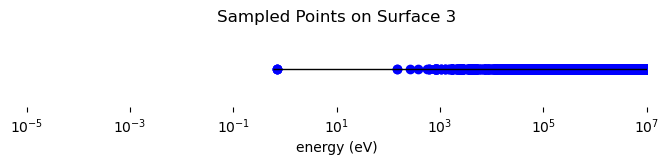

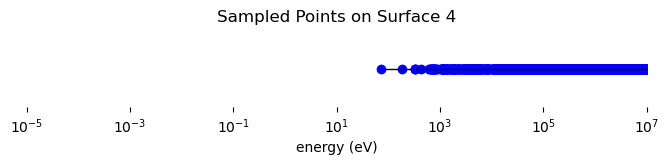

In [14]:
import numpy as np

energy_bounds = expansion.energy_bounds

for surface in range(4):
    plt.figure(figsize=(8, 1))  # Make it a horizontal strip

    # Plot the points on a line
    plt.scatter(samples[surface][:,2], np.zeros_like(samples[surface][:,2]), marker='o', color='b')

    # Draw the line
    plt.hlines(0, min(samples[surface][:,2]) - 0.1, max(samples[surface][:,2]) + 0.1, colors='black', linewidth=1)

    # Remove y-axis
    plt.yticks([])
    plt.box(False)  # Remove the surrounding box
    plt.xlabel('energy (eV)')
    plt.xlim(energy_bounds[surface][0], energy_bounds[surface][1])
    plt.xscale('log')
    plt.title(f'Sampled Points on Surface {surface + 1}')

And it would seem that, despite the low energy biasing, that the ensemble sampler correctly samples from the high energy regions of the outgoing flux